# 06 - For JLab Submission

* I was invited to send over my trained model for evaluation!
* The model needs changing to be compliant with the rules

> Submitted models will be
loaded as-is from a single submitted HDF5 compatible with keras.models.load model(). The loaded model
will then be fed a final set of data (TEST) that will conform to the formats outlined above. No post
processing on the model’s output will be performed, meaning the models are expected to provide two
real number outputs such that the first output has been trained to give θ and the second to give z.

* Change model to give two outputs, not a single array
* Output to HDF5 file compatible with `keras.models.load_model()`

In [1]:
%matplotlib inline

## Generator based on JLab Starter Code:

In [2]:
import os
import sys
import gzip
import pandas as pd
import numpy as np
import math

width  = 36
height = 100
batch_size = 32

train_df = pd.read_csv('../TRAIN/track_parms.csv')
train_df = train_df.rename(columns={'phi': 'theta'})
valid_df = pd.read_csv('../VALIDATION/track_parms.csv')
valid_df = valid_df.rename(columns={'phi': 'theta'})
STEP_SIZE_TRAIN = len(train_df)/batch_size
STEP_SIZE_VALID = len(valid_df)/batch_size

In [3]:
def generate_arrays_from_file(path, labels_df):

    images_path = os.path.join(path, 'images.raw.gz')
    print('Generator created for: {}'.format(images_path))

    batch_input           = []
    batch_labels_theta      = []
    batch_labels_z        = []
    idx = 0
    ibatch = 0
    while True:
        with gzip.open(images_path) as f:
            while True:
            
                # Read in one image
                bytes = f.read(width*height)
                if len(bytes) != (width*height): break # break into outer loop so we can re-open file
                data = np.frombuffer(bytes, dtype='B', count=width*height)
                pixels = np.reshape(data, [width, height, 1], order='F')
                pixels_norm = np.transpose(pixels.astype(np.float) / 255., axes=(1, 0, 2) )
                
                # Labels
                theta = labels_df.theta[idx]
                z = labels_df.z[idx]
                idx += 1

                # Add to batch and check if it is time to yield
                batch_input.append( pixels_norm )
                batch_labels_theta.append(theta)
                batch_labels_z.append( z )
                if len(batch_input) == batch_size:
                    ibatch += 1
                    
                    # Since we are training multiple loss functions we must
                    # pass the labels back as a dictionary whose keys match
                    # the layer their corresponding values are being applied
                    # to.
                    labels_dict = {
                        'theta_output' :  np.array(batch_labels_theta),
                        'z_output'   :  np.array(batch_labels_z),        
                    }
                    
                    yield ( np.array(batch_input), labels_dict )
                    batch_input      = []
                    batch_labels_theta = []
                    batch_labels_z   = []

            idx = 0
            f.close()

In [4]:
train_generator = generate_arrays_from_file('../TRAIN', train_df)
valid_generator = generate_arrays_from_file('../VALIDATION', valid_df)

# Double Regression

In [5]:
import tensorflow as tf

In [6]:
def double_regression_model():
    
    image_input = tf.keras.Input(shape=(height, width, 1),
                                 name='image_input')
    
    x = tf.keras.layers.Conv2D(8, (3, 3))(image_input)
    x = tf.keras.layers.Activation(tf.nn.relu)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = tf.keras.layers.Conv2D(12, (3, 3))(x)
    x = tf.keras.layers.Activation(tf.nn.relu)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    #### Theta branch
    theta_branch = tf.keras.layers.Conv2D(16, (2, 2))(x)
    theta_branch = tf.keras.layers.Activation(tf.nn.relu)(theta_branch)
    theta_branch = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(theta_branch)
    
    theta_branch = tf.keras.layers.Conv2D(16, (3, 3))(theta_branch)
    theta_branch = tf.keras.layers.Activation(tf.nn.relu)(theta_branch)
    
    theta_branch = tf.keras.layers.Flatten()(theta_branch)
    
    theta_branch = tf.keras.layers.Dense(16)(theta_branch)
    theta_branch = tf.keras.layers.Activation(tf.nn.relu)(theta_branch)
    theta_branch = tf.keras.layers.Dropout(0.5)(theta_branch)
    output_theta = tf.keras.layers.Dense(1, activation='linear',
                                         name='theta_output')(theta_branch)
    ####
    
    #### Vertex branch
    z_branch = tf.keras.layers.Conv2D(16, (2, 2))(x)
    z_branch = tf.keras.layers.Activation(tf.nn.relu)(z_branch)
    z_branch = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(z_branch)
    
    z_branch = tf.keras.layers.Conv2D(16, (3, 3))(z_branch)
    z_branch = tf.keras.layers.Activation(tf.nn.relu)(z_branch)
    
    z_branch = tf.keras.layers.Flatten()(z_branch)
    
    z_branch = tf.keras.layers.Dense(16)(z_branch)
    z_branch = tf.keras.layers.Activation(tf.nn.relu)(z_branch)
    z_branch = tf.keras.layers.Dropout(0.5)(z_branch)
    output_z = tf.keras.layers.Dense(1, activation='linear',
                                     name='z_output')(z_branch)
    ####
    
    model = tf.keras.Model(inputs=image_input, outputs=[output_theta, output_z])
    
    model.compile(
        optimizer='adam', 
        loss={
            'theta_output': 'mean_squared_error',
            'z_output': 'mean_squared_error'
        },
        metrics=['mse']
    )
    
    return model

In [7]:
model = double_regression_model()

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 100, 36, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 98, 34, 8)    80          image_input[0][0]                
__________________________________________________________________________________________________
activation (Activation)         (None, 98, 34, 8)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 49, 17, 8)    0           activation[0][0]                 
______________________________________________________________________________________________

In [41]:
history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=15,
    initial_epoch=6,
)

Epoch 7/15
15625/15625 [==============================] - 448s 29ms/step - loss: 6.9284 - theta_output_loss: 4.0132 - z_output_loss: 2.9152 - theta_output_mse: 4.0132 - z_output_mse: 2.9152 - val_loss: 1.9552 - val_theta_output_loss: 0.4385 - val_z_output_loss: 1.5161 - val_theta_output_mse: 0.4385 - val_z_output_mse: 1.5161
Epoch 8/15
15625/15625 [==============================] - 455s 29ms/step - loss: 6.8516 - theta_output_loss: 3.9992 - z_output_loss: 2.8525 - theta_output_mse: 3.9992 - z_output_mse: 2.8525 - val_loss: 2.4419 - val_theta_output_loss: 0.6680 - val_z_output_loss: 1.7732 - val_theta_output_mse: 0.6680 - val_z_output_mse: 1.7732
Epoch 9/15
15625/15625 [==============================] - 433s 28ms/step - loss: 6.7803 - theta_output_loss: 3.9888 - z_output_loss: 2.7915 - theta_output_mse: 3.9888 - z_output_mse: 2.7915 - val_loss: 1.2448 - val_theta_output_loss: 0.3232 - val_z_output_loss: 0.9212 - val_theta_output_mse: 0.3232 - val_z_output_mse: 0.9212
Epoch 10/15
15625/1

## Output the trained model

In [45]:
model.save('jlab_submission.h5')

In [46]:
model.save_weights('jlab_submission_weights.h5')

## Visualizations, Evaluation

In [47]:
valid_generator = generate_arrays_from_file('../VALIDATION', valid_df)
y_pred = model.predict_generator(valid_generator, steps=STEP_SIZE_VALID)

Generator created for: ../VALIDATION/images.raw.gz


In [48]:
valid_df['theta_pred'] = y_pred[0][:50000]

In [49]:
import matplotlib.pyplot as plt

(array([4654., 5704., 4309., 4520., 5211., 5037., 5220., 5146., 5655.,
        4560.]),
 array([-8.753129  , -7.0206075 , -5.2880864 , -3.5555649 , -1.8230436 ,
        -0.09052229,  1.641999  ,  3.3745203 ,  5.107042  ,  6.839563  ,
         8.572084  ], dtype=float32),
 <a list of 10 Patch objects>)

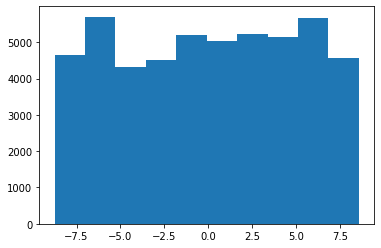

In [50]:
plt.hist(y_pred[0])

In [51]:
valid_df = valid_df.eval('d_theta = theta - theta_pred')

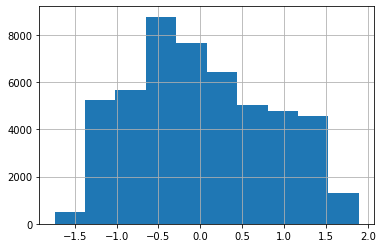

In [52]:
valid_df.d_theta.hist()

## Train the original approach

* Has many more hyperparameters

In [63]:
def original_double_regression_model():
    
    image_input = tf.keras.Input(shape=(height, width, 1),
                                 name='image_input')
    
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(image_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    def branch(input_layer, output_name):
        y = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
        y = tf.keras.layers.BatchNormalization()(y)
        y = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(y)

        y = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(y)
        y = tf.keras.layers.BatchNormalization()(y)
        y = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(y)
        
        y = tf.keras.layers.Flatten()(y)
        y = tf.keras.layers.Dense(64, activation='relu')(y)
        y = tf.keras.layers.BatchNormalization()(y)
        y = tf.keras.layers.Dropout(0.5)(y)
        output = tf.keras.layers.Dense(
            1, activation='linear',
            name=output_name
        )(y)
        return output
    
    theta_output = branch(x, 'theta_output')
    z_output = branch(x, 'z_output')
    
    model = tf.keras.Model(inputs=image_input, outputs=[theta_output, z_output])
    
    model.compile(
        optimizer='adam', 
        loss={
            'theta_output': 'mean_squared_error',
            'z_output': 'mean_squared_error'
        }
    )
    
    return model

In [64]:
original_model = original_double_regression_model()
original_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 100, 36, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 98, 34, 32)   320         image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 98, 34, 32)   128         conv2d_23[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D) (None, 49, 17, 32)   0           batch_normalization_11[0][0]     
____________________________________________________________________________________________

In [65]:
train_generator = generate_arrays_from_file('../TRAIN', train_df)
valid_generator = generate_arrays_from_file('../VALIDATION', valid_df)

In [69]:
original_history = original_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=7,
    initial_epoch=5    
)

Epoch 6/7
15625/15625 [==============================] - 2982s 191ms/step - loss: 3.1132 - theta_output_loss: 1.6800 - z_output_loss: 1.4332 - val_loss: 0.5874 - val_theta_output_loss: 0.0724 - val_z_output_loss: 0.5148
Epoch 7/7
15625/15625 [==============================] - 3238s 207ms/step - loss: 3.0813 - theta_output_loss: 1.6700 - z_output_loss: 1.4113 - val_loss: 0.5998 - val_theta_output_loss: 0.1260 - val_z_output_loss: 0.4736


In [75]:
original_history.history.keys()

dict_keys(['loss', 'theta_output_loss', 'z_output_loss', 'val_loss', 'val_theta_output_loss', 'val_z_output_loss'])

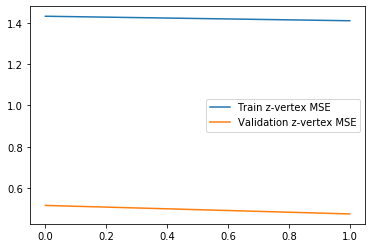

In [76]:
plt.plot(original_history.history['z_output_loss'], label="Train z-vertex MSE")
plt.plot(original_history.history['val_z_output_loss'], label="Validation z-vertex MSE")
plt.legend()
plt.show()


In [78]:
original_model.save('../models/jlab_submission.h5')

In [79]:
import keras

Using TensorFlow backend.


In [81]:
reloaded_model = tf.keras.models.load_model('../models/jlab_submission.h5')